# CI/CD and Git as Source of Truth

## Setup Project

Create project to separate resources.

In [1]:
import mlrun

In [2]:
project = mlrun.get_or_create_project(name="berkeley-mlops", context=".")

> 2022-09-06 21:01:31,778 [info] loaded project berkeley-mlops from MLRun DB


In this example, we will create a project with 2 MLRun functions and a single pipeline that orchestrates them. The pipeline steps will be the following:
- `get-data` - Get iris data from sklearn
- `train-model` - Train model via sklearn

---

### Add Functions to Project

We have prepared the three pipeline steps outlined above: `get-data`, `train-model`, and `deploy-model`. We can add the functions to a project like so:

In [3]:
project.set_function(name='get-data', func='functions/get_data.py', kind='job', image='mlrun/mlrun')
project.set_function(name='train-model', func='functions/train.py', kind='job', image='mlrun/mlrun')

---

### Write Pipeline

Next, we will define the pipeline that orchestrates the two comoponents. This pipeline will be very simple, however you can create very complex pipelines with branches, conditions, and more.

In [4]:
%%writefile pipelines/training_pipeline.py
from kfp import dsl
import mlrun

@dsl.pipeline(
    name="batch-pipeline-academy",
    description="Example of batch pipeline for Iguazio Academy"
)
def pipeline(label_column: str, test_size=0.2):
    
    # Ingest the data set
    ingest = mlrun.run_function(
        'get-data',
        handler='prep_data',
        params={'label_column': label_column},
        outputs=["iris_dataset"]
    )
    
    # Train a model   
    train = mlrun.run_function(
        "train-model",
        handler="train_model",
        inputs={"dataset": ingest.outputs["iris_dataset"]},
        params={
            "label_column": label_column,
            "test_size" : test_size
        },
        outputs=['model']
    )

Overwriting pipelines/training_pipeline.py


---

### Add Pipeline to Project

In [5]:
project.set_workflow(name='train', workflow_path="pipelines/training_pipeline.py")
project.save()

---

### Run Pipeline via Python SDK

The default behavior of the pipeline is to run using Kubeflow Pipelines so we do not need to explicitly specify the engine

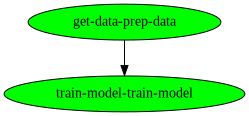

uid,start,state,name,parameters,results
...165fc001,Sep 06 21:02:15,completed,train-model-train_model,label_column=targettest_size=0.2,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0
...1c4133ec,Sep 06 21:01:54,completed,get-data-prep_data,label_column=target,num_rows=150


In [6]:
run_id = project.run(
    name="train",
    arguments={'label_column': 'target', 'test_size' : 0.2}, # Arguments in Key Value format
    sync=True, # Get latest versions of all MLRun functions before running,
    watch=True # Wait for pipeline to execute before continuing (prints out graph)
)

---

### Run Pipeline via CLI

Like the Python SDK, the CLI has many options for running projects. The CLI is often used in CI/CD pipelines rather than the Python SDK, but that is user preference.

Run `mlrun project --help` for more info. To execute our pipeline, run the following:

In [7]:
!mlrun project ./ --run train --arguments label_column=target --arguments test_size=0.2

Loading project berkeley-mlops into ./:

kind: project
metadata:
  name: berkeley-mlops
  created: '2022-09-06T20:56:24.657000+00:00'
spec:
  functions:
  - url: functions/get_data.py
    name: get-data
    kind: job
    image: mlrun/mlrun
  - url: functions/train.py
    name: train-model
    kind: job
    image: mlrun/mlrun
  workflows:
  - name: train
    path: pipelines/training_pipeline.py
    engine: null
  artifacts: []
  source: ''
  desired_state: online
  owner: nick
status:
  state: online

running workflow train file: None
Missing type name was inferred as "Float" based on the value "0.2".
> 2022-09-06 21:03:07,156 [info] submitted pipeline berkeley-mlops-train 2022-09-06 21-03-07 id=ad3776e6-97f4-4268-9981-9dd68d8d8f25
> 2022-09-06 21:03:07,157 [info] Pipeline run id=ad3776e6-97f4-4268-9981-9dd68d8d8f25, check UI for progress
Pipeline started in project berkeley-mlops id=ad3776e6-97f4-4268-9981-9dd68d8d8f25, check progress in https://dashboard.default-tenant.app.us-sales-35